In [1]:
#we're using v3 for the paper
import math
import numpy as np
import pandas as pd
#import tensorflow as tf
import tensorflow.compat.v1 as tf #shap isn't compatible with tf v2
tf.disable_v2_behavior()

from sklearn.model_selection import train_test_split
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pandas as pd
import numpy as np
import os
import math
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
import shap

low_memory=False
%config Completer.use_jedi = False

DATA_LOCATION = "data/combined/"
MODELS_LOCATION = "models/"
VERSION = "v3"
print("loaded lib")

Instructions for updating:
non-resource variables are not supported in the long term
loaded lib


In [2]:
#https://github.com/rodrigobressan/keras_boston_housing_price
#https://towardsdatascience.com/keras-101-a-simple-and-interpretable-neural-network-model-for-house-pricing-regression-31b1a77f05ae
play_by_play_season_game_team_bins = pd.read_csv("cleanedData/play_by_play_season_game_team_bins.csv")

#play_by_play_season_bins_clustered %>% select(x_court_bin,y_court_bin,cluster,season,playoffs) %>% inner_join(play_by_play_season_game_team_bins, by=c("x_court_bin","y_court_bin","season","playoffs")) -> play_by_play_season_game_team_bins_clustered

play_by_play_season_bins_clustered = pd.read_csv("cleanedData/play_by_play_season_bins_clustered.csv")
play_by_play_season_bins_clustered_select = play_by_play_season_bins_clustered[["x_court_bin","y_court_bin","cluster"]].copy()
play_by_play_season_game_team_bins_clustered = pd.merge(play_by_play_season_game_team_bins, play_by_play_season_bins_clustered_select, on=["x_court_bin","y_court_bin"])

#change back to below for per game clustering
#play_by_play_season_bins_clustered_select = play_by_play_season_bins_clustered[["x_court_bin","y_court_bin","cluster","season","playoffs"]].copy()
#play_by_play_season_game_team_bins_clustered = pd.merge(play_by_play_season_game_team_bins, play_by_play_season_bins_clustered_select, on=["x_court_bin","y_court_bin","season","playoffs"])



# play_by_play_season_game_team_bins_clustered %>% group_by(cluster,season,playoffs, game_id, team, opponent_team) %>% summarize(estimated_points = sum(estimated_points),
#                                                                                                           estimated_shot_attempts=sum(estimated_shot_attempts),
#                                                                                                           estimated_shot_attempts_game_total=max(estimated_shot_attempts_game_total),
#                                                                                                           points_game_total = max(points_game_total),
#                                                                                                           opponent_estimated_points = sum(opponent_estimated_points),
#                                                                                                           opponent_estimated_shot_attempts=sum(opponent_estimated_shot_attempts),
#                                                                                                           opponent_estimated_shot_attempts_game_total=max(opponent_estimated_shot_attempts_game_total),
#                                                                                                           opponent_points_game_total = max(opponent_points_game_total),) %>% mutate(
#                                                                                                             shot_percentage = estimated_shot_attempts/estimated_shot_attempts_game_total,
#                                                                                                             opponent_shot_percentage = opponent_estimated_shot_attempts/opponent_estimated_shot_attempts_game_total,
#                                                                                                             shot_percentage_difference=shot_percentage-opponent_shot_percentage,
#                                                                                                             points_difference=points_game_total-opponent_points_game_total) -> play_by_play_season_game_team_bins_clustered_summary
play_by_play_season_game_team_bins_clustered_summary = play_by_play_season_game_team_bins_clustered.groupby(['cluster','season','playoffs', 'game_id', 'team', 'opponent_team']).agg(estimated_points=('estimated_points', sum),
                                                                                                                                                                                     estimated_shot_attempts=('estimated_shot_attempts', sum),
                                                                                                                                                                                     estimated_shot_attempts_game_total=('estimated_shot_attempts_game_total', max),
                                                                                                                                                                                     points_game_total=('points_game_total', max),
                                                                                                                                                                                     opponent_estimated_points=('opponent_estimated_points', sum),
                                                                                                                                                                                     opponent_estimated_shot_attempts=('opponent_estimated_shot_attempts', sum),
                                                                                                                                                                                     opponent_estimated_shot_attempts_game_total=('opponent_estimated_shot_attempts_game_total', max),
                                                                                                                                                                                     opponent_points_game_total=('opponent_points_game_total', max),).reset_index()
play_by_play_season_game_team_bins_clustered_summary['shot_percentage'] = play_by_play_season_game_team_bins_clustered_summary['estimated_shot_attempts']/play_by_play_season_game_team_bins_clustered_summary['estimated_shot_attempts_game_total']
play_by_play_season_game_team_bins_clustered_summary['opponent_shot_percentage'] = play_by_play_season_game_team_bins_clustered_summary['opponent_estimated_shot_attempts']/play_by_play_season_game_team_bins_clustered_summary['opponent_estimated_shot_attempts_game_total']
play_by_play_season_game_team_bins_clustered_summary['shot_percentage_difference'] = play_by_play_season_game_team_bins_clustered_summary['shot_percentage']-play_by_play_season_game_team_bins_clustered_summary['opponent_shot_percentage']
play_by_play_season_game_team_bins_clustered_summary['points_difference'] = play_by_play_season_game_team_bins_clustered_summary['points_game_total']-play_by_play_season_game_team_bins_clustered_summary['opponent_points_game_total']

#both team FE and clusters
play_by_play_season_game_team_bins_clustered_summary['cluster'] = play_by_play_season_game_team_bins_clustered_summary['cluster'].astype(str)
#play_by_play_season_game_team_bins_clustered_summary.to_csv("play_by_play_season_game_team_bins_clustered_summary.csv")
X = play_by_play_season_game_team_bins_clustered_summary[['points_difference','game_id','cluster','shot_percentage_difference','team','opponent_team','season']].copy()
#X = play_by_play_season_game_team_bins_clustered_summary[['cluster','shot_percentage_difference']].copy()


onehotencoder = OneHotEncoder()
#reshape the 1-D country array to 2-D as fit_transform expects 2-D and finally fit the object
cluster = onehotencoder.fit_transform(X.cluster.values.reshape(-1,1)).toarray()
#To add this back into the original dataframe
dfOneHot = pd.DataFrame(cluster, columns = ["cluster"+str(int(i)) for i in range(X.cluster.nunique())])
dfOneHot = dfOneHot.mul(X['shot_percentage_difference'], axis=0) #interact
X = pd.concat([X, dfOneHot], axis=1)
X= X.drop(['cluster','shot_percentage_difference'], axis=1)
X.to_csv("before.csv")
X = X.groupby(['game_id','team','opponent_team','season','points_difference']).sum().reset_index()
X.to_csv("after.csv")
y = X[['points_difference']].copy()
#X
#y
X= X.drop(['game_id','points_difference'], axis=1)


X['team_season'] = X['team'] + "_" + X['season'].astype(str)
X['opponent_team_season'] = X['opponent_team'] + "_" + X['season'].astype(str)
X= X.drop(['team','opponent_team','season'], axis=1)

team = onehotencoder.fit_transform(X.team_season.values.reshape(-1,1)).toarray()
dfOneHot_team = pd.DataFrame(team, columns = ["team_season_"+str(name) for name in (X.team_season.sort_values().unique())])
#X = pd.concat([X, dfOneHot], axis=1)
X= X.drop(['team_season'], axis=1)

opponent_team = onehotencoder.fit_transform(X.opponent_team_season.values.reshape(-1,1)).toarray()
dfOneHot_opponent_team = pd.DataFrame(opponent_team, columns = ["team_season_"+str(name) for name in (X.opponent_team_season.sort_values().unique())])
#X = pd.concat([X, dfOneHot], axis=1)
X= X.drop(['opponent_team_season'], axis=1)

dfOneHot = dfOneHot_team - dfOneHot_opponent_team

X = pd.concat([X, dfOneHot], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [3]:
X_train

,cluster0,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,team_season_ATL_2016,team_season_ATL_2017,team_season_ATL_2018,...,team_season_UTA_2016,team_season_UTA_2017,team_season_UTA_2018,team_season_UTA_2019,team_season_UTA_2020,team_season_WAS_2016,team_season_WAS_2017,team_season_WAS_2018,team_season_WAS_2019,team_season_WAS_2020
9070,-0.009775,0.000000,0.039260,-0.016024,0.0,-0.013461,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11172,-0.000401,0.000000,-0.052248,0.065166,0.0,-0.012517,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3143,-0.016156,0.000000,-0.044045,-0.059527,0.0,0.119728,0.0,0.0,-1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11591,-0.051546,0.000000,-0.115752,0.053444,0.0,0.113854,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6314,-0.083117,0.000000,-0.022026,-0.010413,0.0,0.115556,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5218,-0.053119,-0.000601,0.014200,0.093839,0.0,-0.054320,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0
12252,-0.010245,0.000000,0.005391,-0.029230,0.0,0.034084,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1346,0.161191,0.000000,-0.157112,-0.039679,0.0,0.035600,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11646,0.005925,0.000000,0.019341,0.024252,0.0,-0.049518,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 64)                9664      
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dense_3 (Dense)             (None, 256)               33024     
                                                                 
 dense_4 (Dense)             (None, 512)               131584    
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dense_7 (Dense)             (None, 64)              

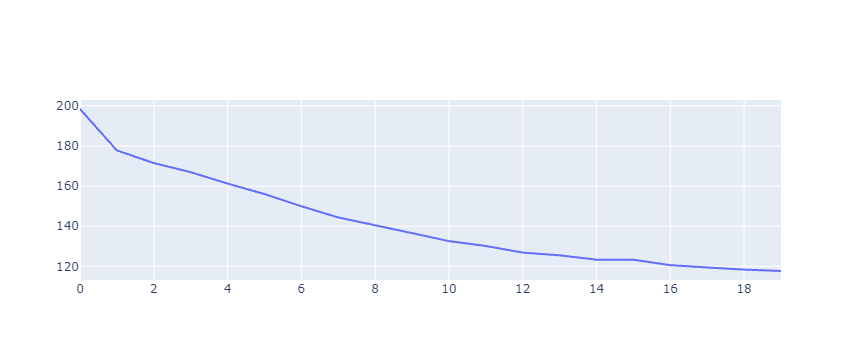

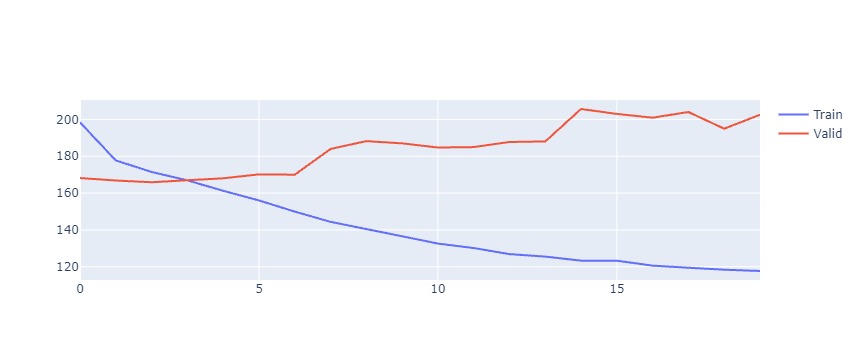

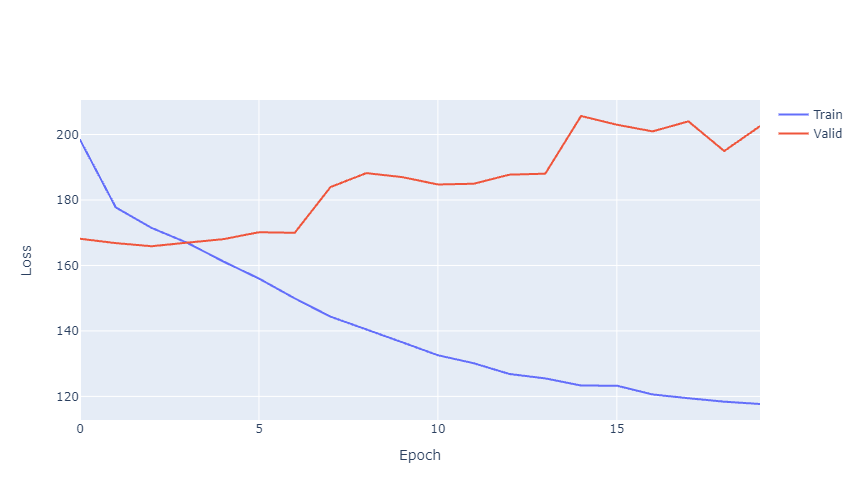

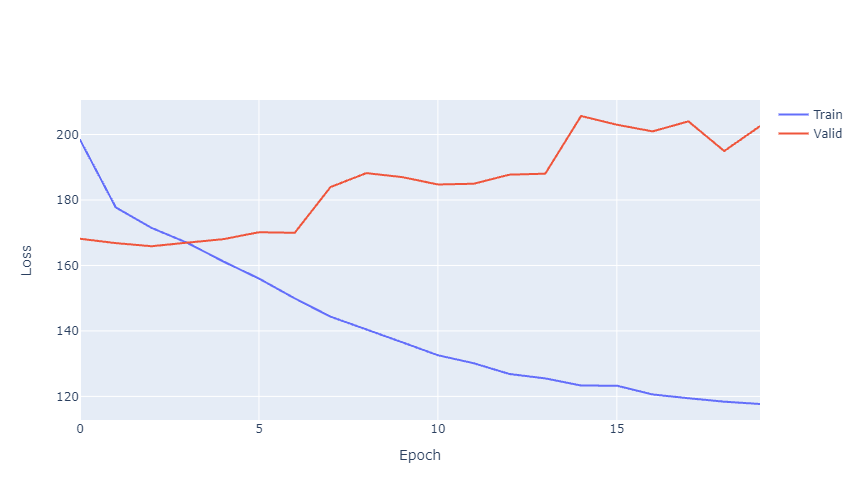

2181

3744

Mean squared error on test data:  234.2193830441206
Mean absolute error on test data:  11.996971
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 64)                9664      
                                                                 
 dropout_28 (Dropout)        (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dense_3 (Dense)             (None, 256)               33024     
                                                                 
 dropout_29 (Dropout)        (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 512)               131584    
                      

In [11]:
X_train_no_cluster = X_train.drop(['cluster0','cluster1','cluster2','cluster3','cluster4','cluster5','cluster6'], axis=1)
X_test_no_cluster = X_test.drop(['cluster0','cluster1','cluster2','cluster3','cluster4','cluster5','cluster6'], axis=1)




model = Sequential()
model.add(Dense(64, input_shape=(len(X_train_no_cluster.columns), ), activation='relu', name='dense_1'))
model.add(Dense(128, activation='relu', name='dense_2'))
model.add(Dense(256, activation='relu', name='dense_3'))
model.add(Dense(512, activation='relu', name='dense_4'))
model.add(Dense(256, activation='relu', name='dense_5'))
model.add(Dense(128, activation='relu', name='dense_6'))
model.add(Dense(64, activation='relu', name='dense_7'))
model.add(Dense(1, activation='linear', name='dense_output'))
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

history = model.fit(X_train_no_cluster, y_train, epochs=20, validation_split=0.05)

fig = go.Figure()
fig.add_trace(go.Scattergl(y=history.history['loss'],
                    name='Train'))
fig.add_trace(go.Scattergl(y=history.history['val_loss'],
                    name='Valid'))
fig.update_layout(height=500, width=700,
                  xaxis_title='Epoch',
                  yaxis_title='Loss')
fig.show()

prediction = model.predict(X_test_no_cluster)
y_test_prediction = y_test.copy()
y_test_prediction['prediction'] = prediction
y_test_prediction['correct'] = np.where(((y_test_prediction.prediction * y_test_prediction.points_difference) > 0), True, False)
sum(y_test_prediction['correct'])
len(y_test_prediction.index)
mse_nn, mae_nn = model.evaluate(X_test_no_cluster, y_test)
print('Mean squared error on test data: ', mse_nn)
print('Mean absolute error on test data: ', mae_nn)

model = Sequential()
model.add(Dense(64, input_shape=(len(X_train_no_cluster.columns), ), activation='relu', name='dense_1'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu', name='dense_2'))
model.add(Dense(256, activation='relu', name='dense_3'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu', name='dense_4'))
model.add(Dense(256, activation='relu', name='dense_5'))
model.add(Dense(128, activation='relu', name='dense_6'))
model.add(Dense(64, activation='relu', name='dense_7'))
model.add(Dense(1, activation='linear', name='dense_output'))
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

model.summary()
history = model.fit(X_train_no_cluster, y_train, epochs=7, validation_split=0.05)
prediction = model.predict(X_test_no_cluster)
y_test_prediction = y_test.copy()
y_test_prediction['prediction'] = prediction
y_test_prediction['correct'] = np.where(((y_test_prediction.prediction * y_test_prediction.points_difference) > 0), True, False)
#sum(y_test_prediction['correct'])
#len(y_test_prediction.index)
mse_nn, mae_nn = model.evaluate(X_test_no_cluster, y_test)
#print('Mean squared error on test data: ', mse_nn)
#print('Mean absolute error on test data: ', mae_nn)
y_test_prediction.to_csv(MODELS_LOCATION + "/data/predictions_team_FE.csv")

In [5]:
y_test

,points_difference
7548,-13.0
3559,9.0
10975,-13.0
5083,4.0
7462,-7.0
...,...
3844,23.0
9527,-20.0
9030,5.0
9303,-6.0


Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 64)                10112     
                                                                 
 dropout_34 (Dropout)        (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dense_3 (Dense)             (None, 256)               33024     
                                                                 
 dropout_35 (Dropout)        (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 512)               131584    
                                                                 
 dense_5 (Dense)             (None, 256)             

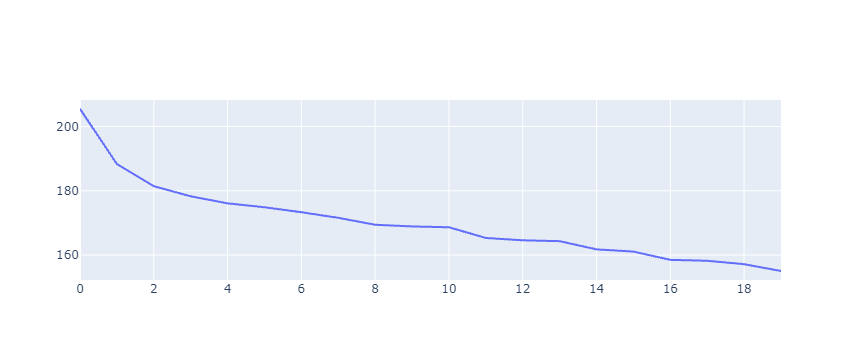

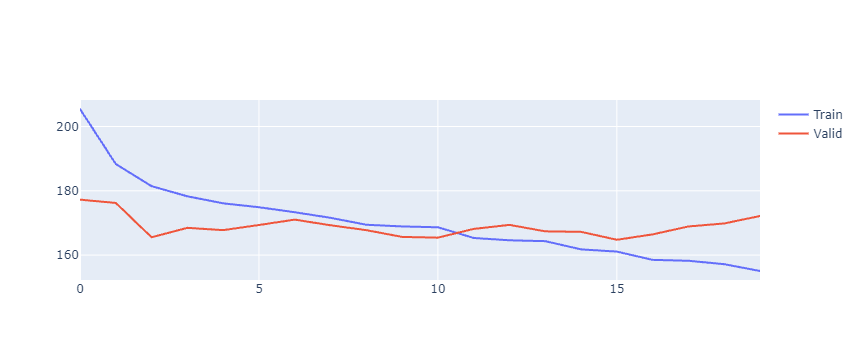

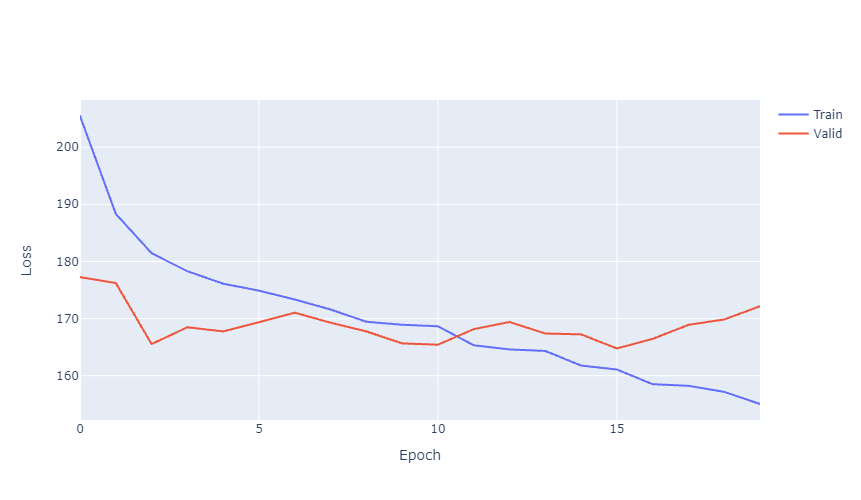

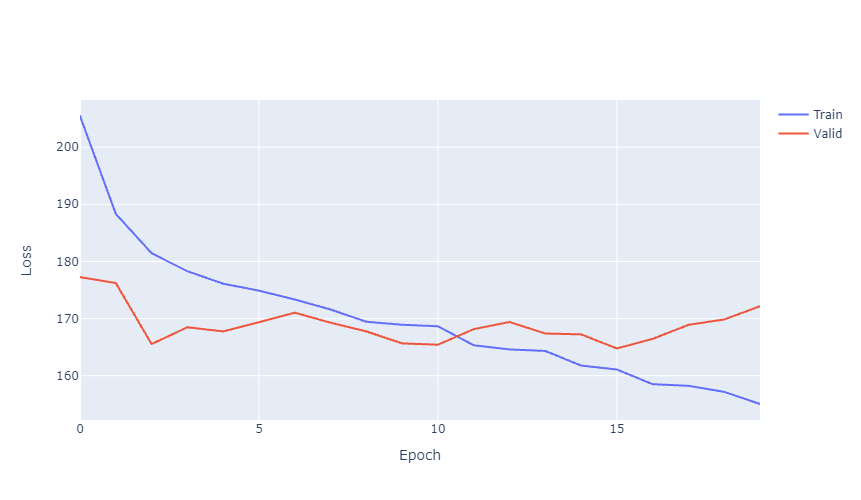

2360

3744

Mean squared error on test data:  188.38581391685028
Mean absolute error on test data:  10.794734
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 64)                10112     
                                                                 
 dropout_36 (Dropout)        (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dense_3 (Dense)             (None, 256)               33024     
                                                                 
 dropout_37 (Dropout)        (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 512)               131584    
                     

In [13]:
model = Sequential()
model.add(Dense(64, input_shape=(len(X_train.columns), ), activation='relu', name='dense_1'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu', name='dense_2'))
model.add(Dense(256, activation='relu', name='dense_3'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu', name='dense_4'))
model.add(Dense(256, activation='relu', name='dense_5'))
model.add(Dense(128, activation='relu', name='dense_6'))
model.add(Dense(64, activation='relu', name='dense_7'))
model.add(Dense(1, activation='linear', name='dense_output'))
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

history = model.fit(X_train, y_train, epochs=20, validation_split=0.05)

fig = go.Figure()
fig.add_trace(go.Scattergl(y=history.history['loss'],
                    name='Train'))
fig.add_trace(go.Scattergl(y=history.history['val_loss'],
                    name='Valid'))
fig.update_layout(height=500, width=700,
                  xaxis_title='Epoch',
                  yaxis_title='Loss')
fig.show()


prediction = model.predict(X_test)
y_test_prediction = y_test.copy()
y_test_prediction['prediction'] = prediction
y_test_prediction['correct'] = np.where(((y_test_prediction.prediction * y_test_prediction.points_difference) > 0), True, False)
sum(y_test_prediction['correct'])
len(y_test_prediction.index)
mse_nn, mae_nn = model.evaluate(X_test, y_test)
print('Mean squared error on test data: ', mse_nn)
print('Mean absolute error on test data: ', mae_nn)


model = Sequential()
model.add(Dense(64, input_shape=(len(X_train.columns), ), activation='relu', name='dense_1'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu', name='dense_2'))
model.add(Dense(256, activation='relu', name='dense_3'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu', name='dense_4'))
model.add(Dense(256, activation='relu', name='dense_5'))
model.add(Dense(128, activation='relu', name='dense_6'))
model.add(Dense(64, activation='relu', name='dense_7'))
model.add(Dense(1, activation='linear', name='dense_output'))
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

model.summary()
history = model.fit(X_train, y_train, epochs=7, validation_split=0.05)
prediction = model.predict(X_test)
y_test_prediction = y_test.copy()
y_test_prediction['prediction'] = prediction
y_test_prediction['correct'] = np.where(((y_test_prediction.prediction * y_test_prediction.points_difference) > 0), True, False)
#sum(y_test_prediction['correct'])
#len(y_test_prediction.index)
mse_nn, mae_nn = model.evaluate(X_test, y_test)
#print('Mean squared error on test data: ', mse_nn)
#print('Mean absolute error on test data: ', mae_nn)
y_test_prediction.to_csv(MODELS_LOCATION + "/data/predictions_team_FE_cluster.csv")
X_test.to_csv(MODELS_LOCATION + "/data/predictions_team_FE_X_test_cluster.csv")

In [7]:

model = Sequential()
model.add(Dense(64, input_shape=(len(X.columns), ), activation='relu', name='dense_1'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu', name='dense_2'))
model.add(Dense(256, activation='relu', name='dense_3'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu', name='dense_4'))
model.add(Dense(256, activation='relu', name='dense_5'))
model.add(Dense(128, activation='relu', name='dense_6'))
model.add(Dense(64, activation='relu', name='dense_7'))
model.add(Dense(1, activation='linear', name='dense_output'))
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

model.summary()
history = model.fit(X, y, epochs=5, validation_split=0.0)
model.save(MODELS_LOCATION+"deep_proportion_cluster_1_tf1_"+VERSION)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 64)                10112     
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dense_3 (Dense)             (None, 256)               33024     
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 512)               131584    
                                                                 
 dense_5 (Dense)             (None, 256)              

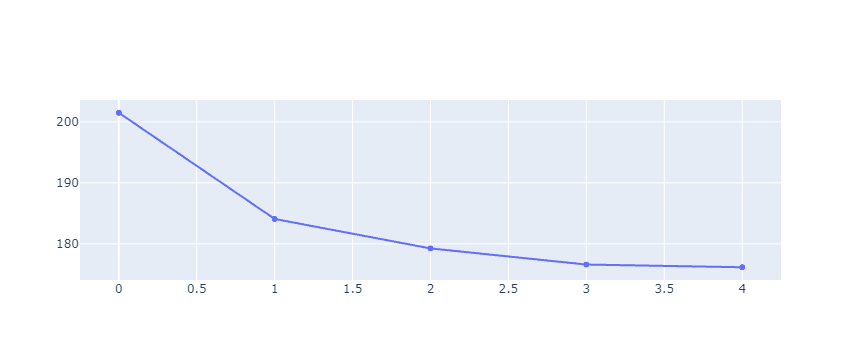

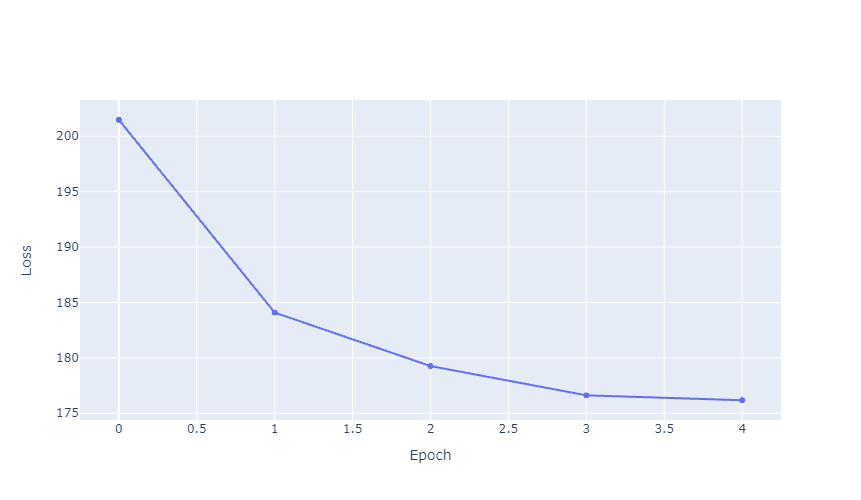

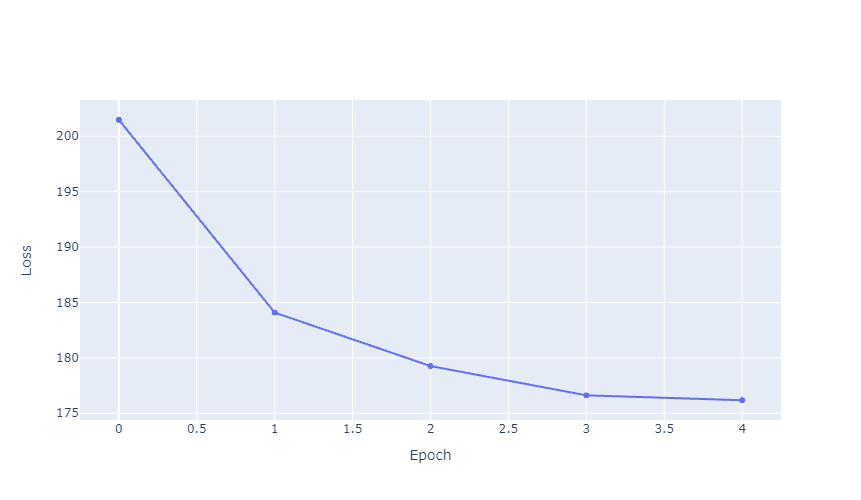

In [8]:
fig = go.Figure()
fig.add_trace(go.Scattergl(y=history.history['loss'],
                    name='Train'))
fig.update_layout(height=500, width=700,
                  xaxis_title='Epoch',
                  yaxis_title='Loss')
fig.show()

SHAP version is: 0.40.0
Tensorflow version is: 2.7.0


,cluster0,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,team_season_ATL_2016,team_season_ATL_2017,team_season_ATL_2018,...,team_season_UTA_2016,team_season_UTA_2017,team_season_UTA_2018,team_season_UTA_2019,team_season_UTA_2020,team_season_WAS_2016,team_season_WAS_2017,team_season_WAS_2018,team_season_WAS_2019,team_season_WAS_2020
0,-0.083510,-0.011494,0.172884,-0.040347,0.0,-0.037533,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.083510,0.011494,-0.172884,0.040347,0.0,0.037533,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.161732,0.000000,-0.131831,-0.037821,0.0,0.007921,0.0,0.0,0.0,0.0,...,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.161732,0.000000,0.131831,0.037821,0.0,-0.007921,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.011200,0.000000,-0.034896,0.001061,0.0,0.045035,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.011200,0.000000,0.034896,-0.001061,0.0,-0.045035,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


G:\My Drive\research\shot_chart\venv_star_destroyer\lib\site-packages\shap\explainers\_deep\deep_tf.py:91: UserWarning:

keras is no longer supported, please use tf.keras instead.

G:\My Drive\research\shot_chart\venv_star_destroyer\lib\site-packages\shap\explainers\_deep\deep_tf.py:96: UserWarning:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.



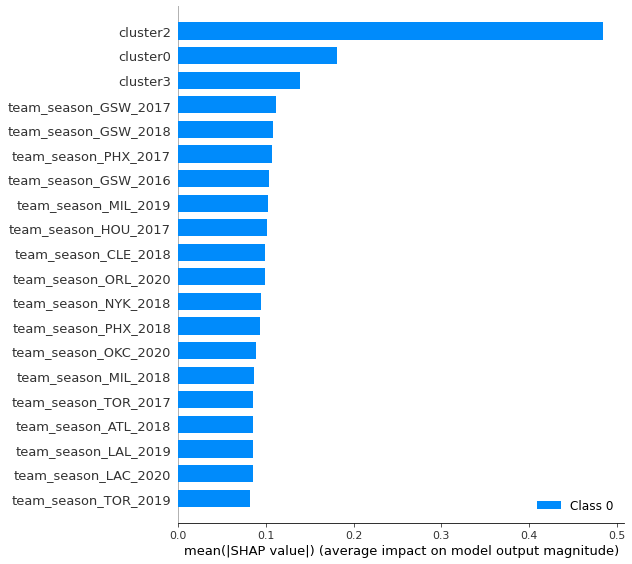

In [9]:
#https://github.com/slundberg/shap

print("SHAP version is:", shap.__version__)
print("Tensorflow version is:", tf.__version__)

X[:6]

shap.initjs()
explainer = shap.Explainer(model)

#shap_values = explainer(X)

explainer = shap.DeepExplainer(model, X.sample(n=5000, random_state=1).values)
shap_values = explainer.shap_values(X.sample(n=5000, random_state=1).values)
shap.summary_plot(shap_values, X.sample(n=5000, random_state=1), plot_type='bar')
shap_values_output = pd.DataFrame(columns = X.keys(), data=shap_values[0])
shap_values_output.to_csv(MODELS_LOCATION + "data/deep_proportion_cluster_1_tf1_shap_"+VERSION+".csv")

cluster0    0.180934
cluster1    0.018610
cluster2    0.484645
cluster3    0.139556
cluster4    0.000011
cluster5    0.076082
cluster6    0.011102
dtype: float64

,cluster0,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6
mean,0.180934,0.01861,0.484645,0.139556,0.000011,0.076082,0.011102


<AxesSubplot:title={'center':'Cluster SHAP Values'}, ylabel='mean(|SHAP value|)'>

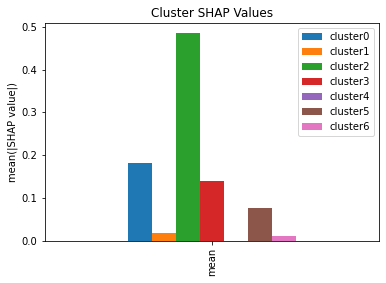

In [10]:
import matplotlib.pyplot as plt
shap_values_output[['cluster0','cluster1','cluster2','cluster3','cluster4','cluster5','cluster6']].mad(axis = 0)
shap_values_output[['cluster0','cluster1','cluster2','cluster3','cluster4','cluster5','cluster6']].apply(abs).agg([np.mean])
shap_values_output[['cluster0','cluster1','cluster2','cluster3','cluster4','cluster5','cluster6']].apply(abs).agg([np.mean]).plot(kind = "bar",ylabel='mean(|SHAP value|)', title='Cluster SHAP Values')
#shap_values_output[['cluster0','cluster1','cluster2','cluster3','cluster4','cluster5','cluster6']].agg([np.mean]).plot(kind = "bar",ylabel='mean(SHAP value)', title='Cluster SHAP Values')


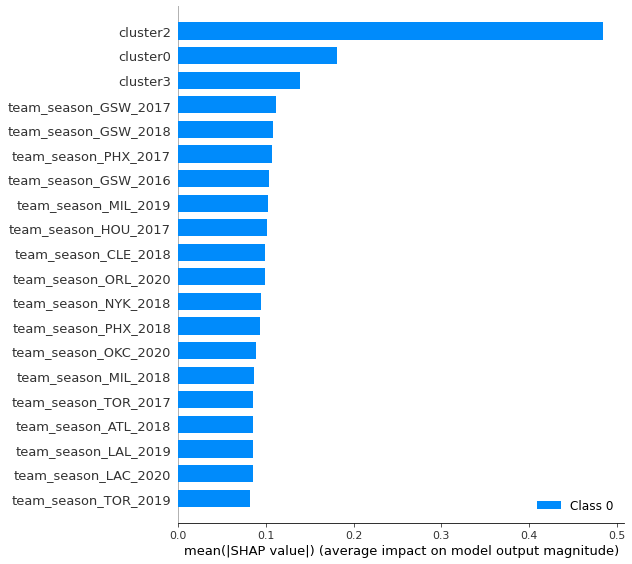

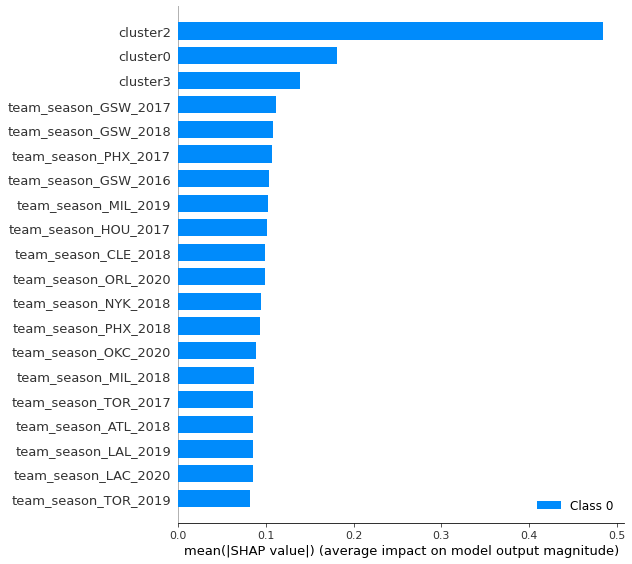

In [11]:
#f = plt.figure()
#https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d
shap.summary_plot(shap_values,  X.sample(n=5000, random_state=1))

shap.summary_plot(shap_values, X.sample(n=5000, random_state=1), plot_type="bar")

In [15]:
original_prediction = X.copy()
original_prediction['original_prediction'] = model.predict(X)
num_clusters = 7
delta = 0.01
for current_cluster in range(num_clusters):
    current_X = X.copy()
    current_X["cluster" + str(current_cluster)] = current_X["cluster" + str(current_cluster)] + delta
    for other_current_cluster in range(num_clusters):
        if(other_current_cluster != current_cluster):
            current_X["cluster" + str(other_current_cluster)] = current_X["cluster" + str(other_current_cluster)] - (delta/(num_clusters-1))
    original_prediction["cluster" + str(current_cluster) + "_delta_prediction"] = model.predict(current_X)
    original_prediction["cluster" + str(current_cluster) + "_me"] = (original_prediction["cluster" + str(current_cluster) + "_delta_prediction"] - original_prediction['original_prediction'])*(0.01/delta) #transform back to a percentage rate of change

original_prediction.to_csv(MODELS_LOCATION + "/data/original_prediction_me_" + VERSION + ".csv")

<AxesSubplot:title={'center':'Average Marginal Effect'}, ylabel='Point Differential'>

,cluster,ame
0,0,-0.013053
1,1,-0.072574
2,2,0.094959
3,3,-0.006448
4,4,0.025328
5,5,0.007582
6,6,-0.035495


,0,1,2,3,4,5,6
mean,0.180934,0.01861,0.484645,0.139556,0.000011,0.076082,0.011102


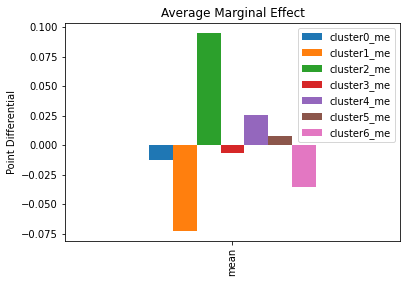

In [27]:
original_prediction[['cluster0_me','cluster1_me','cluster2_me','cluster3_me','cluster4_me','cluster5_me','cluster6_me']].agg([np.mean]).plot(kind = "bar",ylabel='Point Differential', title='Average Marginal Effect')
plt.legend(bbox_to_anchor=(1.0, 1.0))
original_prediction[['cluster0_me','cluster1_me','cluster2_me','cluster3_me','cluster4_me','cluster5_me','cluster6_me']].agg([np.mean]).to_csv(MODELS_LOCATION + "/data/original_prediction_ame_" + VERSION + ".csv")

clusters_ame = original_prediction[['cluster0_me','cluster1_me','cluster2_me','cluster3_me','cluster4_me','cluster5_me','cluster6_me']].agg([np.mean])
for current_cluster in range(num_clusters):
    clusters_ame = clusters_ame.rename(columns={('cluster'+str(current_cluster)+'_me'): (str(current_cluster))})

clusters_ame_tidy = pd.melt(clusters_ame).rename(columns={'variable':'cluster', 'value':'ame'})
clusters_ame_tidy

shap_values_output_mean = shap_values_output[['cluster0','cluster1','cluster2','cluster3','cluster4','cluster5','cluster6']].apply(abs).agg([np.mean])
for current_cluster in range(num_clusters):
    shap_values_output_mean = shap_values_output_mean.rename(columns={('cluster'+str(current_cluster)): (str(current_cluster))})
shap_values_output_mean
shap_values_output_mean_tidy = pd.melt(shap_values_output_mean).rename(columns={'variable':'cluster', 'value':'mean(|SHAP|)'}).reset_index()


In [29]:
play_by_play_season_bins_clustered['cluster'] = play_by_play_season_bins_clustered['cluster'].astype(str)
play_by_play_season_bins_clustered_ame = pd.merge(play_by_play_season_bins_clustered[['x_court_bin', 'y_court_bin', 'cluster']].drop_duplicates().reset_index(), clusters_ame_tidy, on=["cluster"]).reset_index()
play_by_play_season_bins_clustered_ame = pd.merge(play_by_play_season_bins_clustered_ame, shap_values_output_mean_tidy, on=["cluster"]).reset_index()

play_by_play_season_bins_clustered_ame.to_csv(MODELS_LOCATION + "/data/original_prediction_ame_" + VERSION + ".csv")
play_by_play_season_bins_clustered_ame

,index,level_0,index_x,x_court_bin,y_court_bin,cluster,ame,index_y,mean(|SHAP|)
0,0,0,0,-250.0,-17.320508,2,0.094959,2,0.484645
1,1,1,1,-250.0,17.320508,2,0.094959,2,0.484645
2,2,2,2,-250.0,51.961524,2,0.094959,2,0.484645
3,3,3,3,-250.0,86.602540,2,0.094959,2,0.484645
4,4,4,6,-240.0,-34.641016,2,0.094959,2,0.484645
...,...,...,...,...,...,...,...,...,...
680,680,680,677,250.0,86.602540,0,-0.013053,0,0.180934
681,681,681,678,250.0,121.243557,0,-0.013053,0,0.180934
682,682,682,679,250.0,155.884573,0,-0.013053,0,0.180934
683,683,683,682,260.0,0.000000,0,-0.013053,0,0.180934
